# Importing modules I need

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from torch.utils.data import TensorDataset , DataLoader

# Reading dataset (It has been preprocessed)

In [2]:
house_data = pd.read_csv(r"C:\Users\Mohammad\Desktop\House-Price-Prediction-in-Tehran\HomeDataset.csv")

# EDA (Expolarity data analysis)

In [3]:
house_data.head()

,num_floor,unit_per_floor,price,age,statuse,view,doc_status,north,sought,west,...,kitch,service,floor_covering,open,parking,warehouse,balcony,equipment,address_encoded,room_to_area
0,4.0,1,1.183908e+08,27.0,8,22.0,10.0,0.0,1.0,0.0,...,50.0,15.0,15.0,1.0,1.0,1.0,1.0,6,1.212189e+08,0.022989
1,5.0,2,1.400000e+08,0.0,8,22.0,10.0,1.0,0.0,0.0,...,50.0,15.0,10.0,1.0,1.0,1.0,1.0,20,1.060243e+08,0.023810
2,5.0,1,1.363636e+08,0.0,8,22.0,10.0,0.0,1.0,0.0,...,50.0,15.0,10.0,1.0,1.0,1.0,1.0,21,1.168818e+08,0.030303
3,4.0,1,5.250000e+07,18.0,8,22.0,3.0,0.0,1.0,0.0,...,50.0,5.0,10.0,1.0,0.0,0.0,1.0,3,9.027674e+07,0.037500
4,4.0,4,1.400000e+08,3.0,8,22.0,10.0,1.0,0.0,0.0,...,50.0,15.0,10.0,1.0,1.0,0.0,1.0,18,1.381376e+08,0.015385


# Drop Nan & Duplicates data

In [4]:
house_data = house_data.dropna()
house_data = house_data.drop_duplicates()

In [5]:
house_data.shape

(932, 25)

In [6]:
house_data.columns

Index(['num_floor', 'unit_per_floor', 'price', 'age', 'statuse', 'view',
       'doc_status', 'north', 'sought', 'west', 'east', 'floor', 'area',
       'num_sleep', 'tel', 'kitch', 'service', 'floor_covering', 'open',
       'parking', 'warehouse', 'balcony', 'equipment', 'address_encoded',
       'room_to_area'],
      dtype='object')

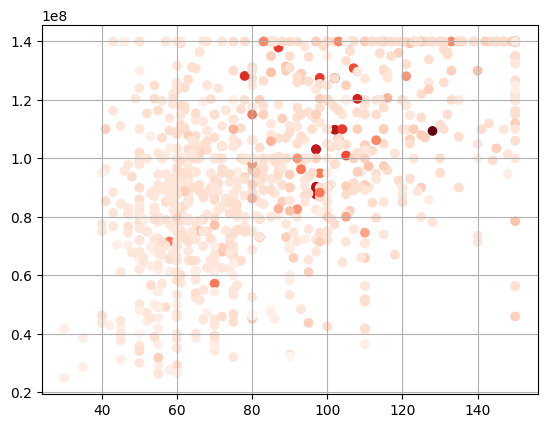

In [7]:
plt.scatter(house_data.area , house_data.price , cmap = "Reds" , c = house_data["num_floor"] )
plt.grid(True)
plt.style.use("ggplot")
plt.show()

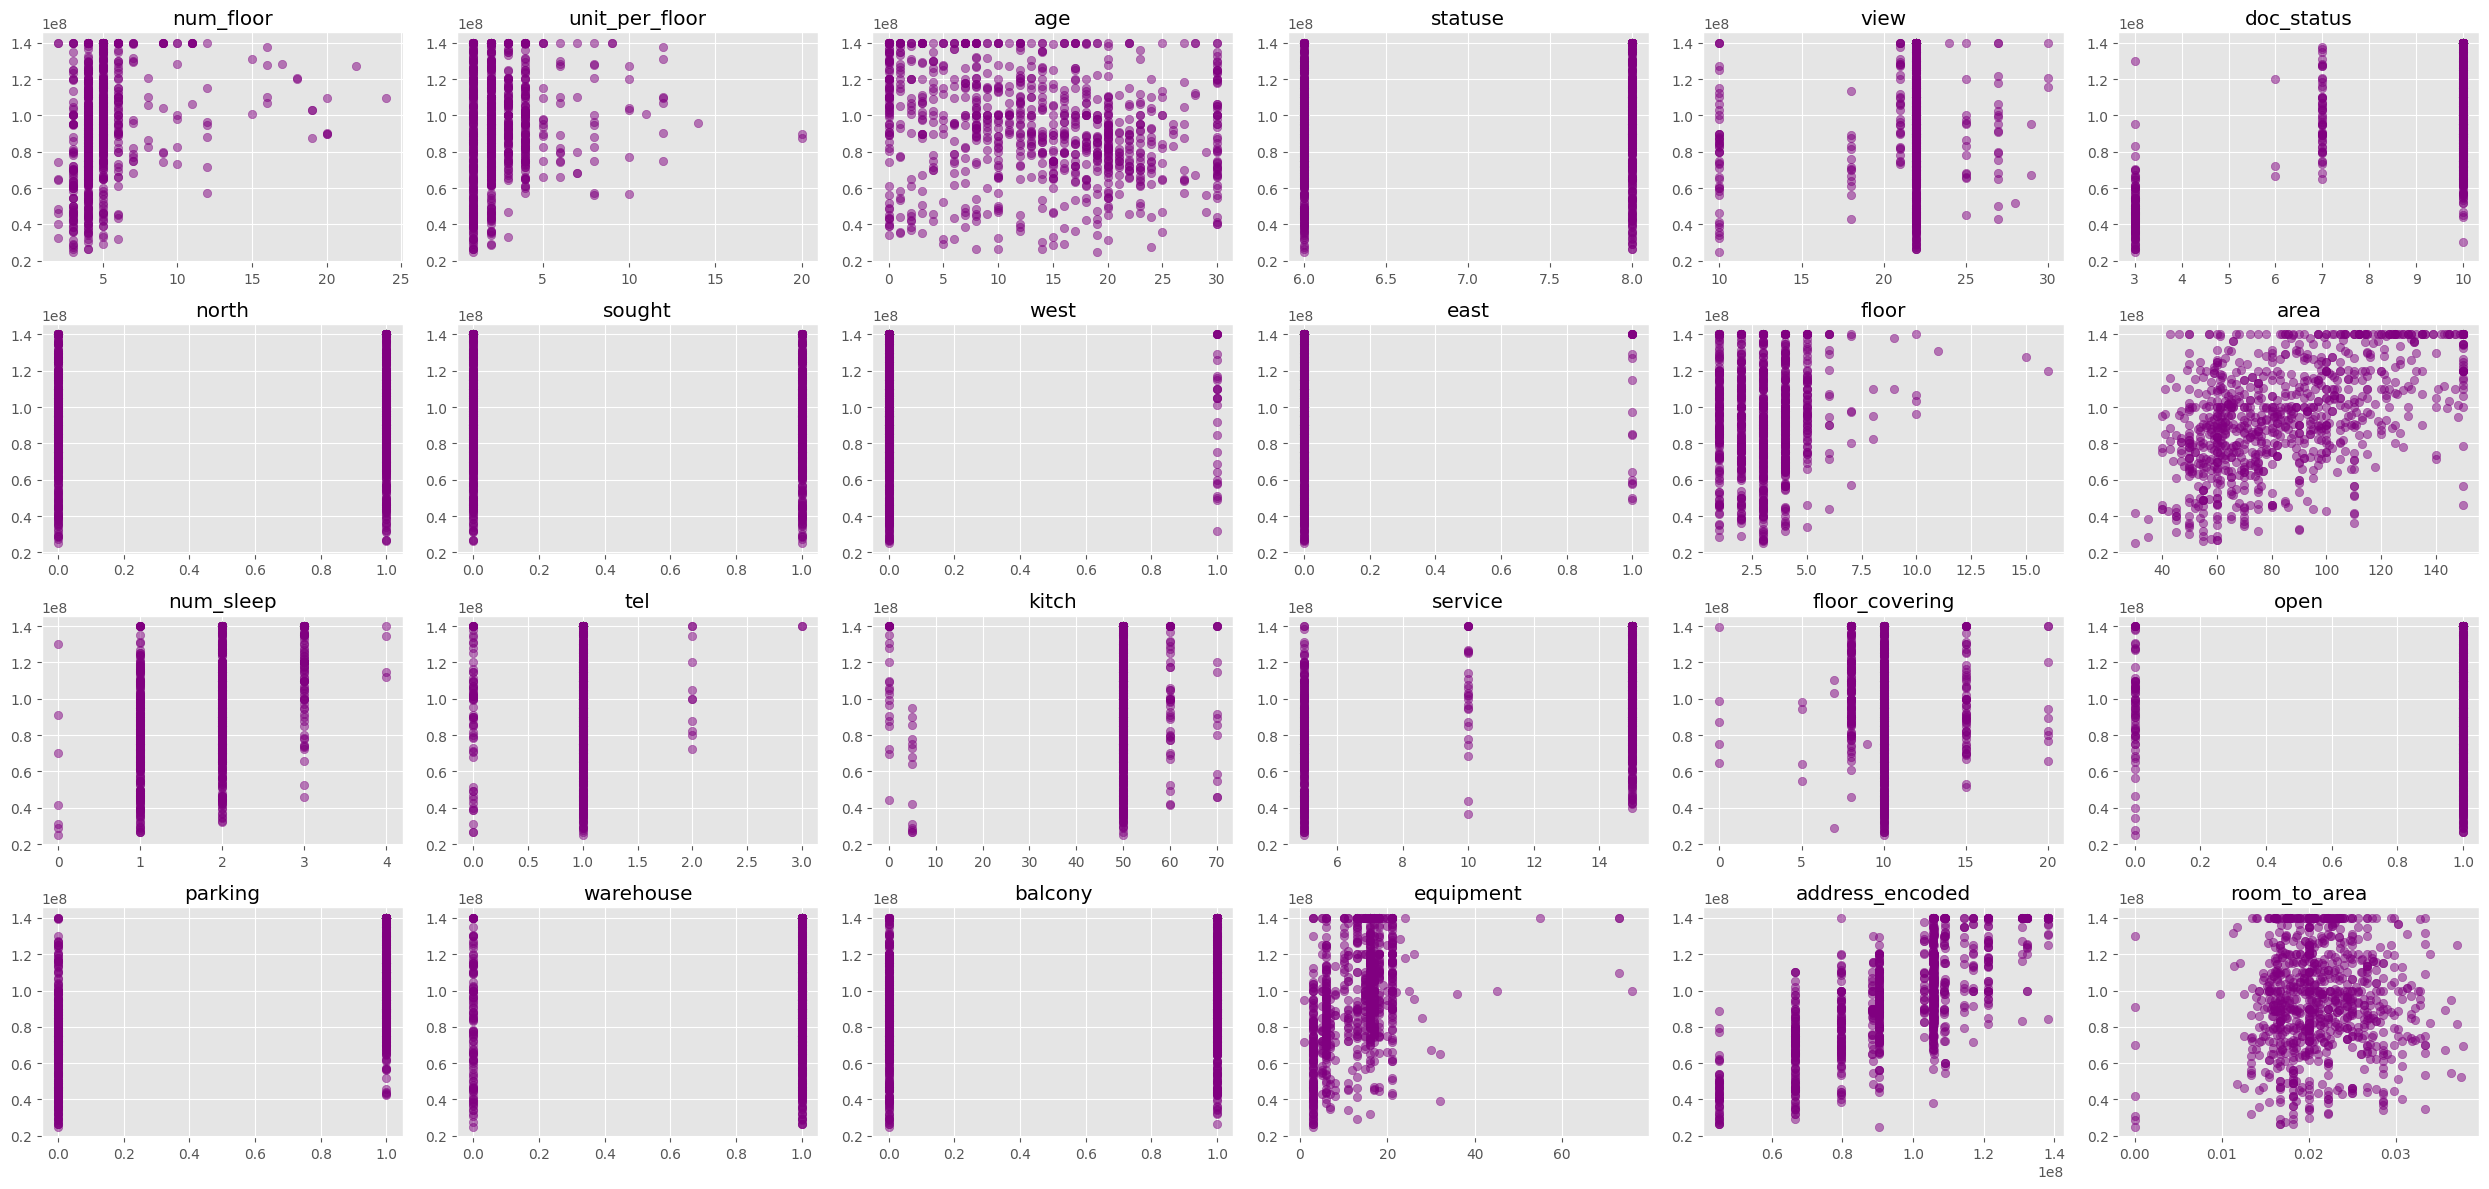

In [8]:

fig, axes = plt.subplots(4, 6, figsize=(25,12))
for i, col in enumerate(house_data.drop("price" , axis = 1)):
    ax = axes[i//6, i%6]
    ax.scatter(house_data[col], house_data.price, alpha=0.5 , c = "purple")
    ax.set_title(col)
plt.tight_layout()
plt.show()


# Defining Features & Targets

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
input_data = house_data.drop("price" , axis = 1).values
price_data = house_data.price.values.reshape(-1 , 1)

# Dispense data to train & validation & test

In [11]:
input_train , input_test , price_train , price_test = train_test_split(input_data , price_data , test_size = .2 , random_state = 42 )

In [12]:
input_validation , input_test , price_validation , price_test = train_test_split(input_test , price_test , test_size = .5 , random_state = 42)

# Scaling data ---> MinMaxScaler

In [13]:
input_scaler = MinMaxScaler()

input_train_scaled = input_scaler.fit_transform(input_train)
input_validation_scaled = input_scaler.transform(input_validation)
input_test_scaled = input_scaler.transform(input_test)


price_scaler = MinMaxScaler()

price_train_scaled = price_scaler.fit_transform(price_train)
price_validation_scaled = price_scaler.transform(price_validation)
price_test_scaled = price_scaler.transform(price_test)


# Convert data to tensor

In [14]:
input_train_scaled_tensor = torch.tensor(input_train_scaled , dtype = torch.float32 , device = device)
price_train_scaled_tensor = torch.tensor(price_train_scaled , dtype = torch.float32 , device = device)
price_test_scaled_tensor = torch.tensor(price_test_scaled , dtype = torch.float32 , device = device)
input_validation_scaled_tensor = torch.tensor(input_validation_scaled , dtype = torch.float32 , device = device)
input_test_scaled_tensor = torch.tensor(input_test_scaled , dtype = torch.float32 , device = device)
price_validation_scaled_tensor = torch.tensor(price_validation_scaled , dtype = torch.float32 , device = device)

# Neural Network Architecture

In [16]:
class PredictionModel(nn.Module):


  def __init__(self):

    super().__init__()
    self.fully_connected_1 = nn.Linear(in_features = 24 , out_features = 16 , bias = True)
    self.fully_connected_2 = nn.Linear(in_features = 16 , out_features = 8)
    self.fully_connected_3 = nn.Linear(in_features = 8 , out_features = 4)
    self.fully_connected_4 = nn.Linear(in_features = 4 , out_features = 1)
    self.activation_function = nn.ReLU()

  def forward(self , x):

    x = self.fully_connected_1(x)
    x = self.activation_function(x)

    x = self.fully_connected_2(x)
    x = self.activation_function(x)

    x = self.fully_connected_3(x)
    x = self.activation_function(x)

    x = self.fully_connected_4(x)

    return x

# Optimizer ---> Adam

In [17]:
model = PredictionModel()
validation_list = []
train_list = []
test_list = []
cost_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = .01)
epochs = 755

# Train loop with Batch Gradient decsent

100 : 0.013110773637890816 , validation: 0.011464915238320827 , test : 0.01343227457255125
200 : 0.011587313376367092 , validation: 0.011219535954296589 , test : 0.013554016128182411
300 : 0.010554971173405647 , validation: 0.011382668279111385 , test : 0.01305315736681223
400 : 0.010240931063890457 , validation: 0.012013630010187626 , test : 0.013355935923755169
500 : 0.009984379634261131 , validation: 0.012417146004736423 , test : 0.013785379007458687
600 : 0.008787933737039566 , validation: 0.012389812618494034 , test : 0.011535619385540485
700 : 0.00836955290287733 , validation: 0.013034074567258358 , test : 0.012976692058146


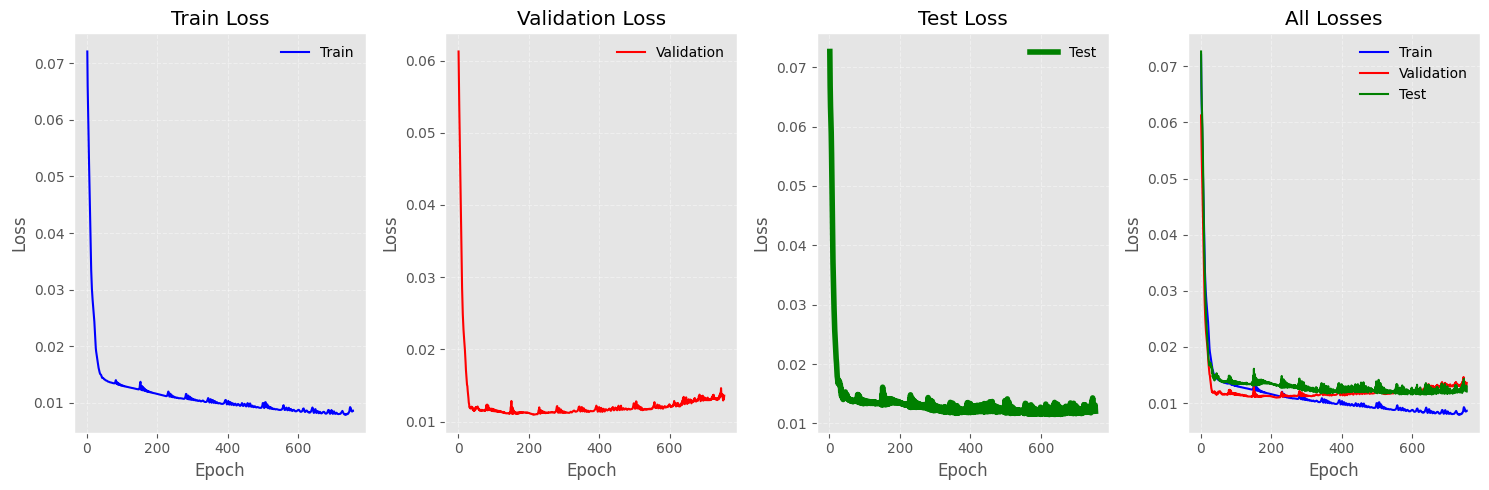

In [18]:
for epoch in range(epochs):
  price_prediction = model.forward(input_train_scaled_tensor)
  loss = cost_function(price_prediction , price_train_scaled_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  train_list.append(loss.detach().numpy())

  model.eval()
  with torch.no_grad():
    price_validation_prediction = model(input_validation_scaled_tensor)
    loss_validation = cost_function(price_validation_prediction , price_validation_scaled_tensor)
    validation_list.append(loss_validation.detach().numpy())
    price_test_prediction = model.forward(input_test_scaled_tensor)
    loss_test = cost_function(price_test_prediction , price_test_scaled_tensor)
    test_list.append(loss_test.detach().numpy())

  if (epoch+1) % 100 == 0:
    print(f"{epoch+1} : {loss.item()} , validation: {loss_validation.item()} , test : {loss_test.item()}") 

epochs_range = range(1, epochs+1)

fig, axes = plt.subplots(1, 4, figsize=(15,5))

axes[0].plot(epochs_range, train_list, c="blue" , label = "Train" )
axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc = "upper right" , frameon = False)
axes[0].grid(True , linestyle = "--" , alpha = .4)

axes[1].plot(epochs_range, validation_list, c="red" , label = "Validation" )
axes[1].set_title("Validation Loss")
axes[1].legend(loc = "upper right" , frameon = False)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True , linestyle = "--" , alpha = .4)

axes[2].plot(epochs_range, test_list, c="green" , label = "Test"  , linewidth = 4)
axes[2].set_title("Test Loss")
axes[2].legend(loc = "upper right" , frameon = False)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].grid(True , linestyle = "--" , alpha = .4)

axes[3].plot(epochs_range , train_list , c = "blue" , label = "Train" )
axes[3].plot(epochs_range , validation_list , c = "red" , label = "Validation" )
axes[3].plot(epochs_range , test_list , c = "green" , label = "Test" )
axes[3].legend(frameon = False , loc = "upper right")
axes[3].set_title("All Losses")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Loss")
axes[3].grid(True , linestyle = "--" , alpha = .4)

plt.tight_layout()
plt.show()




# R2_scores

In [19]:
model.eval()
with torch.no_grad():
  price_train_tensor = price_scaler.inverse_transform(price_train_scaled_tensor)
  price_prediction_unscaled = price_scaler.inverse_transform(price_prediction)
  price_validation_prediction_unscaled = price_scaler.inverse_transform(price_validation_prediction)
  price_test_prediction_unscaled = price_scaler.inverse_transform(price_test_prediction)
  price_test_tensor = price_scaler.inverse_transform(price_test_scaled_tensor)
  price_validation_tensor = price_scaler.inverse_transform(price_validation_scaled_tensor)
  r2_train = r2_score(price_train_tensor , price_prediction_unscaled)
  r2_validation = r2_score(price_validation_tensor , price_validation_prediction_unscaled )
  r2_test = r2_score(price_test_tensor , price_test_prediction_unscaled )


In [20]:
r2_train , r2_validation , r2_test

(0.8680894938631255, 0.7723831917316273, 0.8236387572227278)

# Concatenate validaion & train for Mini Batch Gradient Decsent

In [21]:
input_train_validation = np.concatenate((input_train , input_validation))
price_train_validation = np.concatenate((price_train , price_validation))

# Scaling data with ---> MinMaxScaler

In [22]:
new_input_scaler = MinMaxScaler()
input_train_validation_scaled = new_input_scaler.fit_transform(input_train_validation)
input_test_mbgd_scaled = new_input_scaler.transform(input_test)



new_price_scaler = MinMaxScaler()
price_train_validation_scaled = new_price_scaler.fit_transform(price_train_validation)
price_test_mbgd_scaled = new_price_scaler.transform(price_test)


# Convert targets and inputs to tensors

In [44]:
input_train_validation_scaled_tensor = torch.tensor(input_train_validation_scaled, dtype = torch.float)
input_test_mbgd_scaled_tensor = torch.tensor(input_test_mbgd_scaled, dtype = torch.float)
price_train_validation_scaled_tensor = torch.tensor(price_train_validation_scaled , dtype = torch.float)
price_test_mbgd_scaled_tensor = torch.tensor(price_test_mbgd_scaled , dtype = torch.float)

# Neural network Architecture

In [219]:
class NnPredictionModel(nn.Module):


  def __init__(self):

    super().__init__()
    self.fully_connected_1 = nn.Linear(in_features = 24 , out_features = 16 , bias = True)
    self.fully_connected_2 = nn.Linear(in_features = 16 , out_features = 8)
    self.fully_connected_3 = nn.Linear(in_features = 8 , out_features = 4)
    self.fully_connected_4 = nn.Linear(in_features = 4 , out_features = 1)
    self.activation_function = nn.ReLU()

  def forward(self , x):

    x = self.fully_connected_1(x)
    x = self.activation_function(x)

    x = self.fully_connected_2(x)
    x = self.activation_function(x)

    x = self.fully_connected_3(x)
    x = self.activation_function(x)

    x = self.fully_connected_4(x)

    return x

In [220]:
model_1 = NnPredictionModel()
loss_function = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters() , lr = 1e-2)

# Dataset and Dataloader

In [221]:
dataset = TensorDataset(input_train_validation_scaled_tensor ,price_train_validation_scaled_tensor )

In [222]:
dataloader = DataLoader(dataset , batch_size = 32, shuffle = True)

In [223]:
mbgd_epochs = 30
train_list_mbgd = []
test_list_mbgd = []
mbgd_epochs

30

# Train loop with Mini Batch Gradient Descent

1 ----> Train loss: 0.9465 , Test loss: 0.1121
2 ----> Train loss: 0.0768 , Test loss: 0.0422
3 ----> Train loss: 0.0382 , Test loss: 0.0296
4 ----> Train loss: 0.0311 , Test loss: 0.0241
5 ----> Train loss: 0.0274 , Test loss: 0.0211
6 ----> Train loss: 0.0251 , Test loss: 0.0205
7 ----> Train loss: 0.0226 , Test loss: 0.0170
8 ----> Train loss: 0.0200 , Test loss: 0.0155
9 ----> Train loss: 0.0185 , Test loss: 0.0146
10 ----> Train loss: 0.0178 , Test loss: 0.0160
11 ----> Train loss: 0.0170 , Test loss: 0.0137
12 ----> Train loss: 0.0164 , Test loss: 0.0135
13 ----> Train loss: 0.0159 , Test loss: 0.0148
14 ----> Train loss: 0.0159 , Test loss: 0.0162
15 ----> Train loss: 0.0146 , Test loss: 0.0136
16 ----> Train loss: 0.0142 , Test loss: 0.0142
17 ----> Train loss: 0.0145 , Test loss: 0.0129
18 ----> Train loss: 0.0147 , Test loss: 0.0126
19 ----> Train loss: 0.0145 , Test loss: 0.0129
20 ----> Train loss: 0.0149 , Test loss: 0.0137
21 ----> Train loss: 0.0155 , Test loss: 0.0123
2

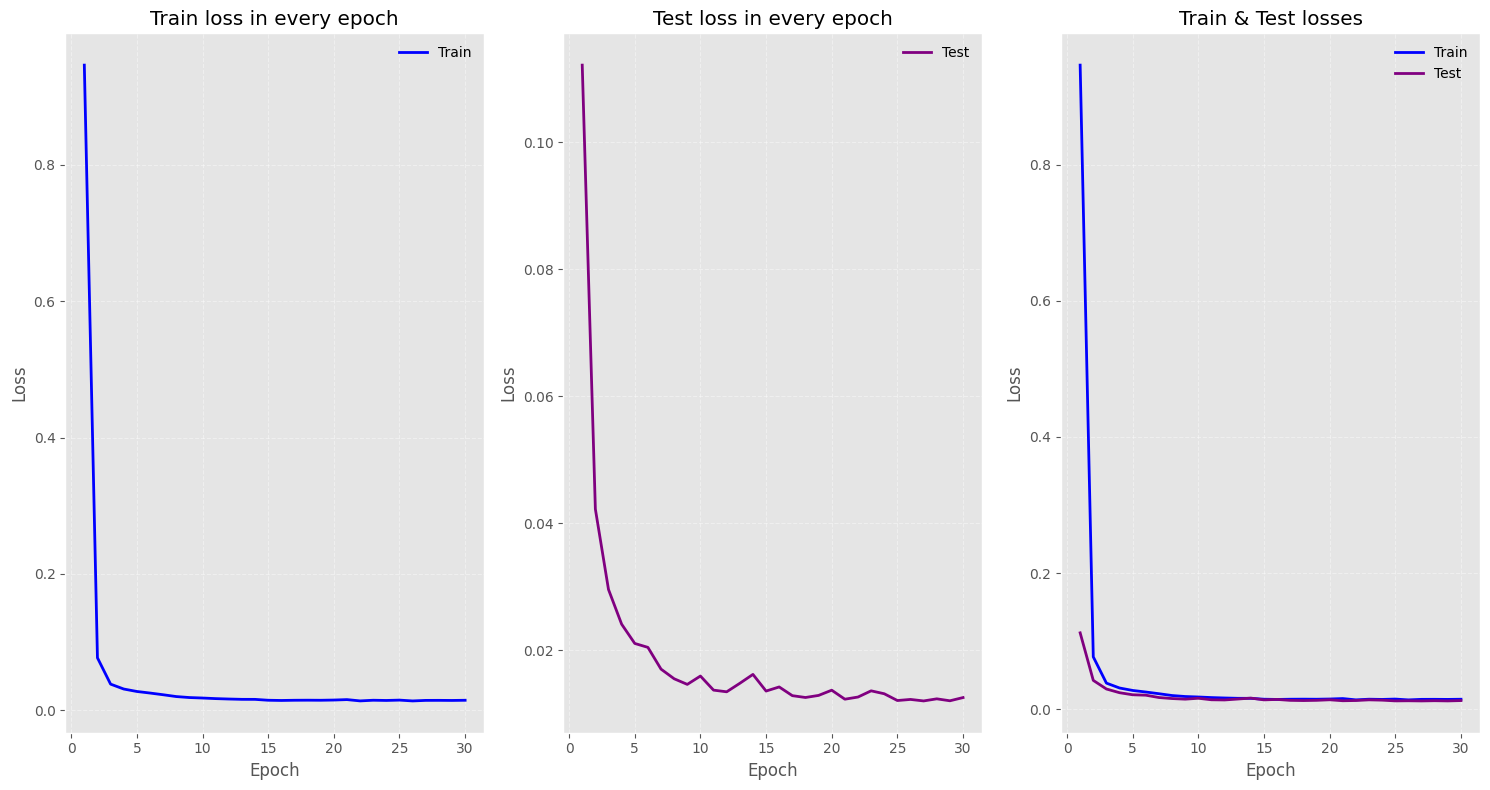

In [224]:
for epoch in range(mbgd_epochs):
    model_1.train()
    batch_losses = []

    for x, y in dataloader:
        
        y_prediction_mbgd = model_1(x)
        loss_mbgd = loss_function(y_prediction_mbgd, y)

        
        optimizer_1.zero_grad()
        loss_mbgd.backward()
        optimizer_1.step()

        batch_losses.append(loss_mbgd.item())

    
    avg_train_loss = sum(batch_losses) / len(batch_losses)

  
    model_1.eval()
    with torch.no_grad():
        y_prediction_mbgd_test = model_1(input_test_mbgd_scaled_tensor)
        loss_mbgd_test = loss_function(y_prediction_mbgd_test,
                                       price_test_mbgd_scaled_tensor)

    train_list_mbgd.append(avg_train_loss)
    test_list_mbgd.append(loss_mbgd_test.item())

    print(f"{epoch+1} ----> Train loss: {avg_train_loss:.4f} , Test loss: {loss_mbgd_test.item():.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

axes[0].plot(range(1, mbgd_epochs+1), train_list_mbgd,
             c="Blue", label="Train", linewidth=2)
axes[0].legend(loc="upper right", frameon=False)
axes[0].grid(True, linestyle="--", alpha=.4)
axes[0].set_title("Train loss in every epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(range(1, mbgd_epochs+1), test_list_mbgd,
             c="Purple", label="Test", linewidth=2)
axes[1].legend(loc="upper right", frameon=False)
axes[1].grid(True, linestyle="--", alpha=.4)
axes[1].set_title("Test loss in every epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

axes[2].plot(range(1, mbgd_epochs+1), train_list_mbgd,
             c="Blue", label="Train", linewidth=2)
axes[2].plot(range(1, mbgd_epochs+1), test_list_mbgd,
             c="Purple", label="Test", linewidth=2)
axes[2].legend(loc="upper right", frameon=False)
axes[2].grid(True, linestyle="--", alpha=.4)
axes[2].set_title("Train & Test losses")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")

fig.tight_layout()
plt.show()

# R2_scores

In [225]:
model_1.eval()
with torch.no_grad():
    y_prediction_mbgd_train = model_1(input_train_validation_scaled_tensor)
    y_prediction_mbgd_train_unscaled = new_price_scaler.inverse_transform(
        y_prediction_mbgd_train.numpy()
    )
    price_train_validation_unscaled = new_price_scaler.inverse_transform(
        price_train_validation_scaled
    )
    r2_train_mbgd = r2_score(price_train_validation_unscaled,
                             y_prediction_mbgd_train_unscaled)
    y_prediction_mbgd_test_unscaled = new_price_scaler.inverse_transform(
        y_prediction_mbgd_test.numpy()
    )
    price_test_unscaled = new_price_scaler.inverse_transform(price_test_mbgd_scaled)
    r2_test_mbgd = r2_score(price_test_unscaled, y_prediction_mbgd_test_unscaled)


In [226]:
r2_train_mbgd , r2_test_mbgd

(0.7976787566708006, 0.8161890283811755)